# Prediccion de precio de casas

![](https://storage.googleapis.com/kaggle-datasets-images/128/270/d149695d1f9a97ec54cf673be6430ad7/dataset-original.jpg)

*Objetivo: predecir precio de casas en King County en el estado de Washington (data de [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)).*


Pensemos primero en un modelo lineal simple utilizando solamente los metros cuadrados:
$$ \log(price) = \beta_{0} + \beta_{1}m2 + \varepsilon $$

Interpretabilidad: la ordenada al origen es el precio inicial de una casa y la pendiente cuanto crece este por metro cuadrado.

En la misma línea: **¿por qué en logaritmos?** -> *Power Law/Fat Tails*

Para medir la bondad de ajuste usamos el error cuadrático medio (ECM):
$$ ECM = \frac{1}{N} \sum_{i=1}^{N}(y_{i} - \hat{f}(x_{i}))^{2} =
          \sum_{i=1}^{N}(\log(price_{i}) - \beta_{0} + \beta_{1}m2_{i})^{2} $$



## Modelo Lineal Univariado

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

### SIN DATOS NO HAY PARAISO
![](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/whatido.jpg)


#### Obteniendo el dataset de Kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanpampliega","key":"b1326920d87a3eafebaa62d19e301f53"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets download -d harlfoxem/housesalesprediction

  0% 0.00/780k [00:00<?, ?B/s]
100% 780k/780k [00:00<00:00, 53.5MB/s]


#### Cargar el dataset con Pandas

In [0]:
def extract_housing_prices_data():
    #url_csv = 'https://storage.googleapis.com/qeds/data/kc_house_data.csv'
    df = pd.read_csv('housesalesprediction.zip')
    return df

In [0]:
df = extract_housing_prices_data()

In [0]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [0]:
df.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10222,3293700496,20141204T000000,450000.0,4,1.75,1850,7730,1.0,0,0,5,7,1100,750,1956,0,98133,47.7481,-122.355,2260,8581
14387,1796000120,20141023T000000,510000.0,4,2.00,2990,102366,1.0,0,0,4,8,2990,0,1974,0,98092,47.3068,-122.088,2820,57140
15232,1926049398,20141013T000000,359000.0,3,2.25,1650,7218,1.0,0,0,3,7,1230,420,1985,0,98133,47.7237,-122.335,1690,7459
18300,2125049133,20141104T000000,715000.0,5,1.75,1920,6500,1.0,0,0,3,7,1260,660,1951,0,98112,47.6394,-122.308,1970,5500
7040,3395800660,20141230T000000,190000.0,3,1.00,1640,8100,1.0,0,0,3,6,1040,600,1939,0,98146,47.4820,-122.340,1600,8100
8378,2426059097,20150305T000000,910000.0,4,2.50,3530,49222,2.0,0,0,4,9,3530,0,1986,0,98072,47.7285,-122.112,3750,49222
18301,7940710100,20140911T000000,559000.0,3,2.50,2010,5200,2.0,0,0,3,8,2010,0,1989,0,98034,47.7142,-122.203,1860,4400
19135,538000450,20140603T000000,315000.0,5,2.50,2090,4698,2.0,0,0,3,7,2090,0,1998,0,98038,47.3538,-122.025,2070,4698
18909,9499200220,20140611T000000,234000.0,3,2.00,1640,5280,1.5,0,0,5,6,1640,0,1910,0,98002,47.3089,-122.213,1160,7875
13181,4027700021,20150311T000000,680000.0,5,3.25,2440,15815,2.0,0,0,3,8,1990,450,2014,0,98155,47.7740,-122.280,2500,14201


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Un poco de EDA

### EDA y ETFL

EDA: Exploratory Data Analysis/Análisis Estadístico Descriptivo

**Data Mining**: en su acepción pura son técnicas para analizar los datos, encontrar patrones y generar insights.

- **Visualizaciones:** univariadas (para un mismo feature), bi-variadas (entre features y target), multivariadas (entre distintos features)
- **Técnicas de estadística clásica:** correlaciones, test de hipótesis, ANOVA.
- **Reducción de dimensionalidad:** PCA, SVD
- **Clustering**

**Objetivos:**
- Comprender el dataset.
- Definir y refinar la selección e ingeniería de atributos que alimentan los modelos.


¿Qué involucra hacer data science en la industria?
**E**xtract **T**ransform **F**it **L**oad

Distribución de tiempos: **E 30\% | T 50\% | F 10\% | L 10\%**



In [0]:
df['bedrooms'].value_counts().to_frame().reset_index().sort_values(by='index')

,index,bedrooms
8,0,13
5,1,199
2,2,2760
0,3,9824
1,4,6882
3,5,1601
4,6,272
6,7,38
7,8,13
9,9,6


In [0]:
df['price'].value_counts()

450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
641500.0      1
575950.0      1
674250.0      1
608700.0      1
884744.0      1
Name: price, Length: 4028, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d628444e0>,
      dtype=object)

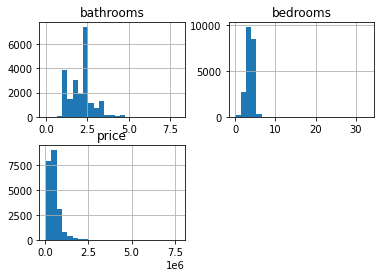

In [0]:
df1 = df[['bedrooms', 'bathrooms', 'price']]
df1.hist(bins=25,xlabelsize='10',ylabelsize='10')

In [0]:
df_corr = df.corr('pearson')
df_corr.style.background_gradient(cmap='coolwarm', axis=None)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


In [0]:
def scatter_wrapper(df, ax=None, x='sqft_living', y='price', color='b'):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=x , y=y, c=color, alpha=0.35, s=1.5, ax=ax)
    return ax

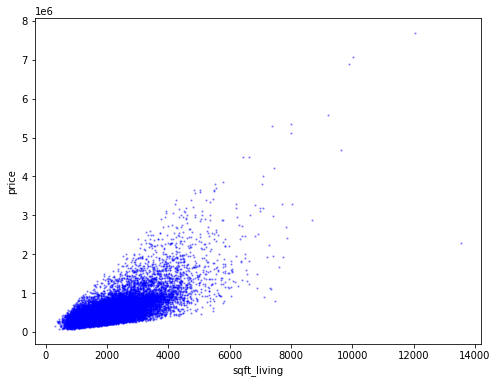

In [0]:
scatter_wrapper(df)

### Preprocesamiento

### Transformacion: Ingenieria

![](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/assets/feml_0102.png)

El "aprendizaje" del modelo dependerá de la información y variabilidad provista por los atributos (*Garbage in - garbage out*).

Existe gran variedad de técnicas para generar/modificar atributos

- **Transformaciones logaritmicas:** tiene sentido cuando variables siguen una distribución asimétrica positiva (masa concentrada en valores pequeños y grandes con poca densidad)
- **Reescalamiento de variables numéricas:** si el modelo es sensible a la escala del atributo es deseable hacer transformaciones tipo *estandarización*.
(Esto puede ser propenso a *data leakage*)
- **Binning:** agrupación en *bins* ordenados
- **One-hot encoding:** transformación de variables categóricas en variables contínuas. ![](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/one_hot.png)





In [0]:
df['date']

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [0]:
pd.to_datetime(df['date']).dt.month

0        10
1        12
2         2
3        12
4         2
         ..
21608     5
21609     2
21610     6
21611     1
21612    10
Name: date, Length: 21613, dtype: int64

In [0]:
def preprocess_data(df):
    df['sales_yr'] = pd.to_datetime(df['date']).dt.year
    df['log_price'] = np.log(df['price'])
    return df

In [0]:
df = preprocess_data(df)

In [0]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_yr', 'log_price'],
      dtype='object')

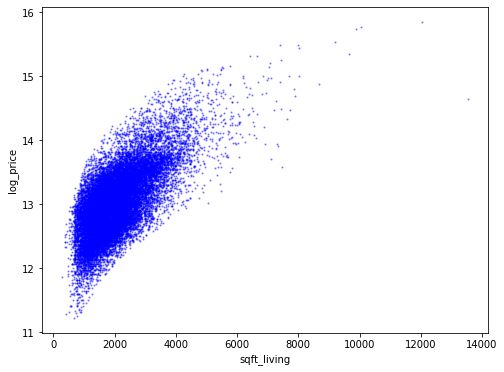

In [0]:
scatter_wrapper(df, y='log_price')

In [0]:
def xy_split(df):
    y = df['log_price']
    X = df.drop(['price', 'log_price', 'date', 'id'], axis=1).copy()
    return X, y

In [0]:
X, y = xy_split(df)

In [0]:
y

0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21608    12.793859
21609    12.899220
21610    12.904459
21611    12.899220
21612    12.691580
Name: log_price, Length: 21613, dtype: float64

In [0]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sales_yr'],
      dtype='object')

In [0]:
def fit(X, y, x_cols=None):
    lr_model = linear_model.LinearRegression()
    X = X if x_cols is None else X[x_cols]
    lr_model.fit(X, y)
    return lr_model

In [0]:
lr_model = fit(X, y, x_cols=['sqft_living'])

In [0]:
beta_0, beta_1 = lr_model.intercept_, lr_model.coef_[0]

In [0]:
beta_0, beta_1

(12.218464096380853, 0.0003987465387451504)

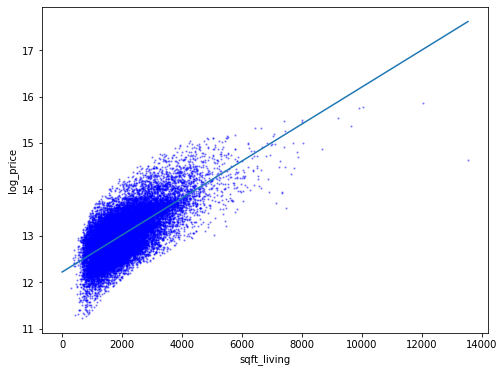

In [0]:
# Plotear predicción
ax = scatter_wrapper(df, y='log_price')
x = np.array([0, df['sqft_living'].max()])
ax.plot(x, beta_0 + beta_1*x)

In [0]:
def predict(model, X, exp=False):
    y_pred = model.predict(X)
    if exp:
        y_pred = np.exp(y_pred)
    return y_pred

In [0]:
predict(lr_model, [[5000]], exp=True) # Nota: esto es un array

array([1486889.31877518])

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
def score(y, y_hat):
    mse = mean_squared_error(y, y_hat)
    print(f"MSE is {mse}")
    return mse

In [0]:
y_hat = predict(lr_model, X[['sqft_living']])

In [0]:
y_hat

array([12.68898501, 13.2432427 , 12.52549893, ..., 12.62518557,
       12.85645856, 12.62518557])

In [0]:
score(y, y_hat)

MSE is 0.14326910852241476


0.14326910852241476

## Ejercicios

### Ejercicios Regresion Lineal Simple

1. **Caching**
Modifique la función que extrae los datos de forma tal que guarde una copia local de los  mismos en caso que esta no exista aun. Si este archivo existe entonces devolver los datos ya guardados a menos que expresamente se quiere rehacer la consulta.
2. **Sistema métrico**
  1. Escriba una función que convierta metros cuadrados a pies cuadrados.
  2. Use la función anterior para estimar el precio de un vivienda con 464 m2 de living.
3. **Regresión lineal multivariada**
  1. Ajuste ahora un modelo con la totalidad de los features: $Y = X\beta + \varepsilon$
  2. En un mismo plano (`sqft_living`, `log_price`), grafique una nube de puntos con la data actual, los valores predicho por el modelo simple y aquellos predichos por este modelo multivariado.
  3. Compare el error cuadrático medio de los dos modelos.
  4. *Feature Engineering:* cree una nueva variable que refleje la fracción de pies no subterraneos y reestime el modelo con este nuevo atributo. ¿Encuentra mejoras en performance?
4. In Sample versus Out Of Sample
  1. Para pensar: ¿con lo hecho hasta ahora puede usted asegurar que su modelo performará correctamente con datos desconocidos?


### Ejercicio 1: Caching

In [0]:
from pathlib import Path

def extract_housing_prices_data_with_cache(cache_fn='hp_data.csv', refresh_cache=False):
    ## TODO: implementar
    return df

In [0]:
df_cache = extract_housing_prices_data_with_cache(refresh_cache=False)

### Ejercicio 2: Sistema metrico

In [0]:
##TODO: implementar

In [0]:
predict(lr_model, [[m2_to_sqft(464)]], exp=True)

### Ejercicio 3: Regresión multivariada y feature engineering

In [0]:
lr_model_full = fit(X, y)

In [0]:
x = 'sqft_living'
size = 1.5
ax = scatter_wrapper(df, y='log_price')
ax.scatter(X[x], predict(lr_model_full, X), c='r', s=size)
ax.scatter(X[x], predict(lr_model, X[[x]]), c='y', s=size)
ax.legend(['data', 'full', 'sqft'])

In [0]:
X_fe = X.copy()
X_fe['pct_sqft_above'] = X_fe['sqft_above'] / X['sqft_living']

In [0]:
X_fe.columns

In [0]:
lr_model_full_above = fit(X_fe, y)

In [0]:
y_hat_full_above = predict(lr_model_full_above, X_fe)
mse_full_above = score(y, y_hat_full_above)

In [0]:
y_hat_full = predict(lr_model_full, X)
mse_full = score(y, y_hat_full)

## Seleccion de Modelos

### Selección de modelos: Conjunto de Validación

Hasta ahora hemos visto un único modelo y calculado una métrica de performance sobre el conjunto de entrenamiento
Pero... **queremos predecir bien sobre datos desconocidos!**


¿Cómo hacerlo? Simulamos la división entre datos conocidos y desconocidos.

*Enfoque de validation/holdout set:* entrenamos el modelo con datos conocidos y validamos las predicciones con el *conjunto de validación* (desconocido)

El conjunto de validación es una submuestra al azar de observaciones del conjunto de entrenamiento (usualmente 20%)

Posible problemas: 

1. La predicción de performance tiene alta variabilidad ya que depende de la participación de observaciones en entrenamiento/validación. 
2. Al achicar el conjunto de entrenamiento podemos estar sobrestimando el error de test.

![](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/holdout.png)

**¿Definido el modelo final: qué observaciones usamos para entrenarlo?**


## Ejercicios

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [0]:
def fit(X, y, x_cols=None, model='lr', max_depth=None):
    if model == 'lr':
        clf = linear_model.LinearRegression()
    elif model == 'dt':
        clf = DecisionTreeRegressor(max_depth=max_depth)
    elif model == 'rf':
        clf = RandomForestRegressor()
    else:
        raise ValueError("Unknown model!")

    X = X if x_cols is None else X[x_cols]
    clf.fit(X, y)
    return clf

In [0]:
dt_model = fit(X, y, model='dt')

In [0]:
dt_model

In [0]:
# Train test split
test_n = 50
X_train = X.iloc[:test_n, :]
y_train = y.iloc[:test_n]
X_test = X.iloc[test_n:, :]
y_test = y.iloc[test_n:]

In [0]:
X.shape, X_train.shape, X_test.shape

In [0]:
def fit_pipeline(X_train, y_train, X_test, y_test, model, max_depth=None):
    m = fit(X_train, y_train, model=model, max_depth=max_depth)
    mses = {}
    for phase in ['train', 'test']:
        X = X_train if phase == 'train' else X_test
        y = y_train if phase == 'train' else y_test
        y_hat = predict(m, X)
        print(f"{phase} phase:")
        mses[phase] = score(y, y_hat)
    return mses

In [0]:
fit_pipeline(X_train, y_train, X_test, y_test, 'lr')

In [0]:
fit_pipeline(X_train, y_train, X_test, y_test, 'dt')

In [0]:
# Hagamos tuning del hiperparámetro de profundidad de los árboles

In [0]:
depths = range(1, 15)

In [0]:
max_depths = range(1, 15)
df_mse = pd.DataFrame()
for max_depth in max_depths:
    mse = fit_pipeline(X_train, y_train, X_test, y_test, 'dt', max_depth=max_depth)
    mse['max_depth'] = max_depth
    df_mse = df_mse.append(mse, ignore_index=True)

In [0]:
fig, ax = plt.subplots(figsize=(10,6))
df_mse.plot(x='max_depth', y='test', c='r', ax=ax)
df_mse.plot(x='max_depth', y='train', c='b', ax=ax)
ax.set_xlabel('max_depth')
ax.set_ylabel('ECM')

### Validación Cruzada

![]()![image.png](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/cv_k_fold.png)

¿Cómo podemos resolver los problemas de la estrategia de holdout?

Una opción es hacer **k-fold cross validation:**

1. Particionar el dataset en $k$ subconjuntos (folds) de tamaño parecido.
2. Usar el enésimo fold como conjunto de validación y el resto como conjunto de entrenamiento computando el ECM en cada caso.
3. Aproximar el error de *test* promediando sobre los ECM: $CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k}EMC_{i}$

Algunas observaciones relevantes:

1. Si hacemos $k = N$ entonces el método se llama *Leave-One-Out Cross-Validation* (LOOCV) (pero esto es costoso computancionalmente)
2. En general se usan valores de $k=5$ o $k = 10$. ¿Por qué?
3. Todos estos métodos asumen que las observaciones son i.i.d...


### Overfitting, modelos e hiperparametros

Con las estrategias de holdout tenemos una forma de aproximar el error de testeo y detectar casos de overfitting: ¿cómo reducimos este problema?

Podemos probar distintos modelos (*no free-lunch theorem*)

Podemos optimizar aquellos parámetros de un mismo modelo que no se derivan del proceso de aprendizaje: los *hiperparámetros*









In [0]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=0)
df_mse_cv = pd.DataFrame()
for max_depth in max_depths:
    df_row = {'max_depth': max_depth}
    max_depth_mses = []
    for train_index, test_index in kf.split(X, y):
        m = DecisionTreeRegressor(max_depth=max_depth)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = m.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        mse = score(y_test, y_hat)
        max_depth_mses.append(mse)
    df_row['max_depth_mse_cv'] = np.mean(max_depth_mses)
    df_mse_cv = df_mse_cv.append(df_row, ignore_index=True)

In [0]:
df_mse_cv

In [0]:
df_mse_cv[df_mse_cv['max_depth_mse_cv'] == df_mse_cv['max_depth_mse_cv'].min()]

### Aca va el slide 17 (cambiando donde dice Lasso por decision tree y alpha por max_depth)... creo que los 2 primeros podrian hacerlos


### Ejercicios Selección de Modelos

1. **Overfitting y validation set**
  1. Escriba una función que separe el conjunto de datos en entrenamiento y validación a partir de un parámetro que determina el tamaño del segundo conjunto.
  2. Utilice ahora la función `model_selection.train_test_split` para realizar la separación del inciso anterior.
  3. Empleando alguna de las dos funciones de los incisos anteriores investigue la existencia de overfitting para distintos tamaños del conjunto de validación.
2. **Más feature engineering: binning y dummies**
  1. Cree una nueva variable `age` que refleje la antigüedad de las casas al ser vendidas.
  2. Genere nuevos features a partir de esta columna usando una estrategia de `binning` (y `dummies`).
  3. Fittee un nuevo modelo Lasso con estos features ampliados y compute el ECM. Comparelo con el modelo completo sin feature engineering.
    1. ¿Estas transformaciones las debe hacer también en el conjunto de validacion?
3. **Validación cruzada e hiperparametros**
  1. Utilizando ahora la función `cross_val_score` del módulo `sklearn.model_section` repita el ejercicio de validación cruzada y obtenga los ECM para cada valor del hiperparámetros $alpha$ (en logaritmos).
  2. Grafique los errores cuadráticos medios resultantes.
  3. A partir del modelo `LassoCV` obtenga nuevamente el hiperparámetro óptimo.




### Ejercicio 1: Overfitting  y validation set

In [0]:
np.random.rand(10)

In [0]:
msk = np.random.rand(len(X)) <= 0.2

In [0]:
msk

In [0]:
msk.sum()

In [0]:
X[~msk]

In [0]:
def train_test_split(X, y, test_size=0.2):
    bool_mask = np.random.rand(len(X)) <= (1 - test_size)
    X_train, X_test = X[bool_mask], X[~bool_mask]
    y_train, y_test = y[bool_mask], y[~bool_mask]
    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [0]:
from sklearn import model_selection

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [0]:
for i in np.arange(0.1, 0.6, 0.1):
    print(f"Test size {i}")
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=i)
    print(f"Model lineal")
    fit_pipeline(X_train, y_train, X_test, y_test, 'lr')
    print(f"Model Decision Tree")
    fit_pipeline(X_train, y_train, X_test, y_test, 'dt')


### Ejercicio 2: binning y dummies

In [0]:
X_bd = X.copy()

In [0]:
X_bd

In [0]:
# TODO: implementar X_bd['age'] = 
X_bd

In [0]:
X_bd['age'].value_counts()

In [0]:
bins = [-2, 0, 5, 10, 25, 50, 75, 100, 100000]
labels = ['<1', '1-5', '6-10', '11-25', '26-50', '51-75', '76-100', '>100']
#TODO: implementar X_bd['age_binned'] = 
X_bd[['age', 'age_binned']]

In [0]:
# TODO implementar dummies X_bd = 
X_bd

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_bd, y, test_size=0.2)

In [0]:
fit_pipeline(X_train, y_train, X_test, y_test, 'dt')

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [0]:
fit_pipeline(X_train, y_train, X_test, y_test, 'dt')

### Ejercicio 3: Validacion cruzada e hiperparametros

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
df_mse_sk = pd.DataFrame()
for max_depth in max_depths:
    df_mse_sk_row = {'max_depth': max_depth}
    cv_score = -cross_val_score(DecisionTreeRegressor(max_depth=max_depth, random_state=0), X, y, cv=5, 
                               scoring='neg_mean_squared_error')
    df_mse_sk_row['cv'] = np.mean(cv_score)
    df_mse_sk = df_mse_sk.append(df_mse_sk_row, ignore_index=True)

In [0]:
df_mse_sk

In [0]:
df_mse_sk[df_mse_sk['cv'] == df_mse_sk['cv'].min()]

## Modelos de Ensamble y Random Forest

### Sobre train, validation, test split

¿Podemos overfittear el conjunto de validación?

Si realizamos muchas pruebas posiblemente si

Por eso en la práctica trabajamos con 3 conjuntos: entrenamiento, validación y testeo.

![](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/tvt.png)

En general se reserva 20% para testing y el remanente se divide en 80% entrenamiento y 20% validación.

Con muchos datos los porcentajes son menores. Es una cuestión de representatividad y no de números.

![](https://raw.githubusercontent.com/petobens/introduccion-ml-aplicado/master/figures/ml-claro-1/sample_size.png)


### Tradeoff de Sesgo-Varianza

¿Cuál es el valor esperado de ECM en una observación de testeo?

Es decir cuál es el ECM promedio si uno estima sucesivas veces $f$ usando muchos conjuntos de entrenamiento y evaluando en cada $x_{0}$ del conjunto de test:

$$E(y_{0} - \hat{f}(x_{0}))^{2} = Var(\hat{f}(x_{0})) +
        \left[Sesgo(\hat{f}(x_{0}))\right]^{2} + Var(\varepsilon)$$

Donde:

La varianza remite a cuánto cambiaría $\hat{f}$ si estimaramos con otro conjunto de entrenamiento (idealmente queremos que sea poco).

El sesgo alude a si $\hat{f}$ está errando consistentemente en las predicciones ($Sesgo(\hat{f}(x_{0})) = E[\hat{f}(x_{0})] - y_{0}$).

El ideal: tener un sesgo bajo y una varianza baja. ¿Es esto posible?

![](https://prateekvjoshi.files.wordpress.com/2015/10/3-bulls-eye.png)

![](https://miro.medium.com/max/492/1*blqnaVEu6Hbc-5ZYeDnU9Q.png)

¿Por qué hay un tradeoff?

- Es fácil obtener un método con bajo sesgo y alta varianza (dibujando una curva que pase por todos los puntos)
- Es fácil obtener un método con bajo o nula varianza y alto sesgo (fitteando una constante)

En general vale lo siguiente:

- Métodos más complejos tienen alta varianza y bajo sesgo.
- El fenómeno de *overfitting* se asocia a escenarios justamente de alta varianza y bajo sesgo.










### Bagging y Árboles aleatorios

**Bagging**

En general vale que agregar observaciones reduce la varianza.

Podemos crear $B$ conjuntos de entrenamiento muestreando de forma aleatoria (y con reposición) del conjunto entrenamiento original (*bootstraping*).

Si luego entrenamos sobre cada conjunto y promediamos reducimos la varianza (y tenemos bajo sesgo)
$$\hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}^{*b}(x)$$

La predicción final es la clase más votada por los $B$ árboles (regla mayoritaria).

**Random Forests**

Ideado por Breiman con el objeto de mejorar aun más la performance predictiva.

Al igual que en bagging se crean $B$ conjuntos de entrenamiento muestreando de forma aleatoria (y con reposición) del conjunto entrenamiento original.

Para cada conjunto se hacer particionamiento recursivo pero al elegir los cortes se emplea un subconjunto aleatorio de la totalidad de atributos (*descorrelacionar*)

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [0]:
fit_pipeline(X_train, y_train, X_test, y_test, 'rf')


# Ejercicio

Utilizando lo aprendido en este notebook y el anterior. 
Desarolle un pipeline para predecir el precio de casas del *Ames Housing dataset*.

El link a la competencia es el siguiente: 
https://www.kaggle.com/c/home-data-for-ml-course/data

Para obetener el dataset de train desde el notebook puede utilizar los siguientes comandos para dejar el archivo `train.csv` en el directorio actual.

```
!kaggle datasets download -d dansbecker/home-data-for-ml-course
!unzip home-data-for-ml-course.zip
```

Comience por explorar los datos y fitear un modelo simple y calcular la métrica de error definida para la competencia para tener un baseline.

Luego, vaya realizando feature engineering progresivamente y verificando como varía su métrica de performance. 

Eventualmente, cuando esté satisfecho con la performance, bajer el archivo `test.csv` de la web de la competencia y verifique la capacidad de generalización de su modelo.

Como paso final, puede submitear su respuesta a la competencia siguiendo el formato descripto en la misma https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation

Para esto hay que generar un archivo CSV con el formato designado y subirlo manualmente a https://www.kaggle.com/c/home-data-for-ml-course/submit

O también puede probar utilizando la commandline app de kaggle de la siguiente manera:


```
!kaggle competitions submit home-data-for-ml-course -f my_submission.csv -m "First Submission @pferrari"
```


Referencia útil:

https://stackoverflow.com/questions/49394737/exporting-data-from-google-colab-to-local-machine/49397357